In [2]:
#!/usr/bin/env python3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import logging
import os
from sklearn import svm
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector



import pickle


In [4]:

# logger.info("-------------------------------------------------------------------------")
# region init
cwd_path = Path(".")
test_data_path = cwd_path / Path("test.csv")
train_data_path = cwd_path / Path("train.csv")
pairplot_file = "pairplot.png"
pairplot_PCA_file = "pairplot_PCA.png"
random_state = 42
grid_search_cv_file = 'grid_search_cv.pkl'
grid_search_cv_path = cwd_path / Path(grid_search_cv_file)
kaggle_path = cwd_path / Path("kaggle_submition.csv")
# endregion 


In [5]:

# region reading from file
# logger.info("reding training file")
df_train = pd.read_csv(train_data_path).drop(["obj_ID", "run_ID", "rerun_ID", "cam_col", "field_ID", "spec_obj_ID", "plate", "MJD", "fiber_ID"], axis=1)
df_train["class"] = df_train["class"].map({"GALAXY": 0, "QSO": 1, "STAR": 2})
# logger.info("remapping of class data {\"GALAXY\": 0, \"QSO\": 1, \"STAR\": 2}")
# logger.info("reding test file")
df_test = pd.read_csv(test_data_path).drop(["obj_ID", "run_ID", "rerun_ID", "cam_col", "field_ID", "spec_obj_ID", "plate", "MJD", "fiber_ID"], axis=1)

# df_nan_values = df_train[df_train.isna().any(axis=1)]
# print(len(df_nan_values))
# endregion 


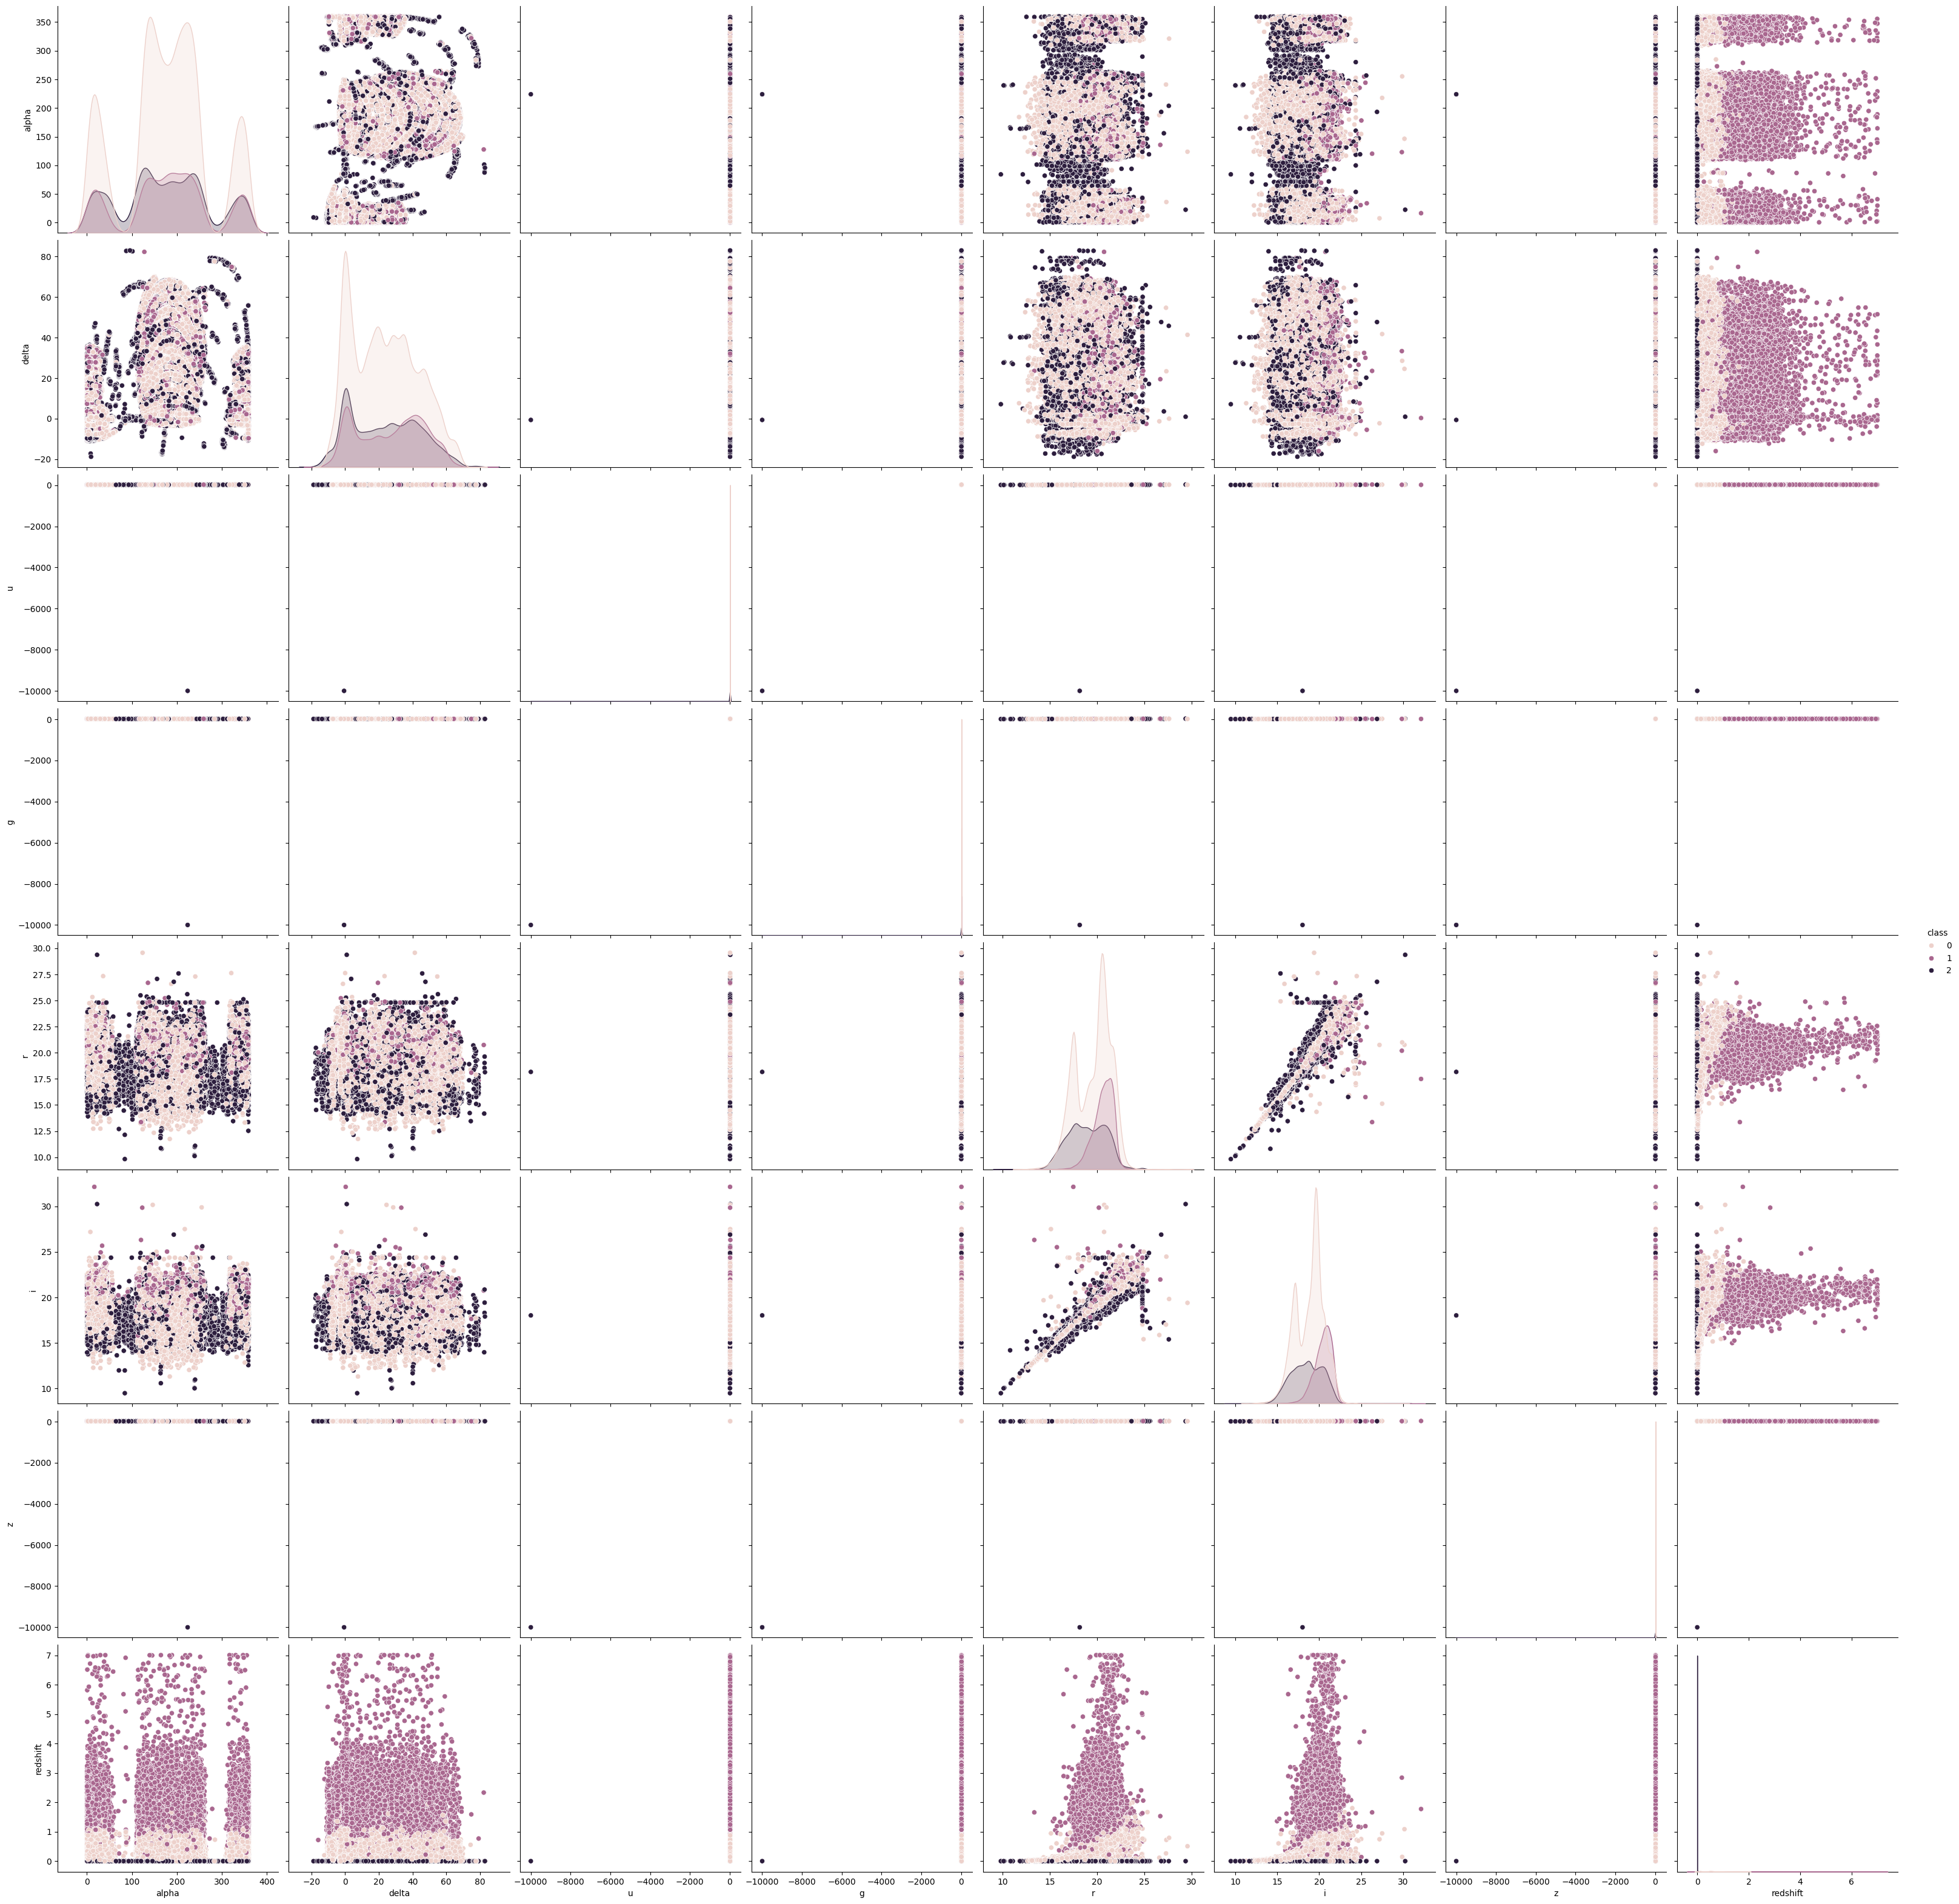

In [6]:

# region pairplot

# logger.info("plotting pairplot")
pairplot = sns.pairplot(df_train, hue="class", height=4.0)
pairplot
# logger.info("saving plot to file %s", pairplot_file)
# pairplot.savefig(cwd_path / Path(pairplot_file))
# plt.clf()



In [ ]:


pca = PCA()
df_pca = pd.DataFrame(pca.fit_transform(df_train.drop("class", axis=1).dropna().to_numpy()))
print(pca.explained_variance_)
explained_variance = str(pca.explained_variance_)
# logger.info("explained_variance %s", explained_variance)

# logger.info("plotting pairplot PCA")
df_pca["class"] = df_train.dropna()["class"].to_numpy()
pairplot = sns.pairplot(df_pca, hue="class", height=4.0)
pairplot
# logger.info("saving plot to file %s", pairplot_PCA_file)
# pairplot.savefig(cwd_path / Path(pairplot_PCA_file))
# plt.clf()


# endregion 


[9.29945774e+03 3.79178861e+03 3.78501641e+02 6.57208479e+00
 1.99730697e+00 4.09759761e-01 3.29058027e-01 4.61861051e-02]


In [ ]:

# region exstracting data as nupy array
# logger.info("converting to numpy array")

train_np_array = df_train.fillna(df_test.mean()).drop("class", axis=1).to_numpy()
train_class_np_array = df_train.fillna(df_test.mean())["class"].to_numpy()
test_np_array = df_test.fillna(df_test.mean()).to_numpy()
# endregion 


In [ ]:

# region spliting data for training
# logger.info("splitting X_train_standardized for training")

# # used for redusing the train size when first starting the task 
# train_test_split =  model_selection.train_test_split(
#     train_np_array, 
#     train_class_np_array, 
#     test_size=0.9, 
#     random_state=random_state
# )

# x_train, x_test, y_train, y_test =  train_test_split

x_train, y_train = (train_np_array, train_class_np_array)
# endregion 


In [ ]:

# region setting upp a pipeline
# logger.info("creating pipeline")
pipeline = Pipeline([
    ('scaling',             StandardScaler()),
    ('preprocessoer',   PCA(n_components=5)),
    ('classifier',          svm.SVC())
])
# endregion 


In [ ]:

# region setting upp grid search
if os.path.isfile(grid_search_cv_path):
    # logger.info("found grid_search_cv file. loading from file.")
    with open(grid_search_cv_path, 'rb') as f:
        grid_search_cv = pickle.load(f)
else:
    # logger.info("creating grid search")
    # logger.info("setting upp parameters")
    param_SVC_C = np.logspace(-1,2.8,25).tolist()
    param_RFC_n_estimator = np.linspace(10, 50,10).astype(int).tolist()
    param_RFC_max_depth = np.linspace(2, 50, 10).astype(int).tolist()
    param_KNN_n_neighbors = np.linspace(2, 10, 8).astype(int).tolist()

    pca = PCA(n_components=5)
    lda = LinearDiscriminantAnalysis()
    sfs = SequentialFeatureSelector(LogisticRegression())
    preprocessoer = [pca, lda]

    param_grid = [
        # {
        #     'preprocessoer': preprocessoer,
        #     'classifier': [svm.SVC()],
        #     'classifier__C': param_SVC_C,
        #     'classifier__kernel': ['rbf', 'poly'],
        # },
        {
            'preprocessoer': preprocessoer,
            'classifier': [RandomForestClassifier()],
            'classifier__n_estimators': param_RFC_n_estimator,
            'classifier__max_depth': param_RFC_max_depth
        },
        {
            'preprocessoer': preprocessoer,
            'classifier': [LogisticRegression()],
            'classifier__C': param_SVC_C,
            'classifier__solver': ['lbfgs', 'newton-cg', 'newton-cholesky'],
        },
        {
            'preprocessoer': preprocessoer,
            'classifier': [KNeighborsClassifier()],
            'classifier__n_neighbors': param_KNN_n_neighbors,
        }
    ]

    # logger.info("defining grid search using param_grid")
    grid_search_cv = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=3
    )

    # logger.info("fitting grid search to training set. this might take a long time")
    grid_search_cv.fit(x_train, y_train)
    # logger.info("dumping grid_search_cv to pickle file")
    with open(grid_search_cv_path, 'wb') as f:
        pickle.dump(grid_search_cv, f)



In [ ]:


best_score = str(grid_search_cv.best_score_)
best_params = str(grid_search_cv.best_params_)
print(f"best score was {best_score}")
print(f"best parameters was {best_params}")

#endregion


In [ ]:

# region visualising result
# logger.info("splitting X_train_standardized for training")

train_test_split =  model_selection.train_test_split(
    train_np_array, 
    train_class_np_array, 
    test_size=0.4, 
    random_state=random_state
)

x_train, x_test, y_train, y_test =  train_test_split
# logger.info("preforming fitting of best pipeline for 60/40 split")
grid_search_cv.best_estimator_.fit(x_train, y_train)
# logger.info("predicting total score")
y_pred = grid_search_cv.predict(x_test)
print(grid_search_cv.best_estimator_.score(x_test, y_test))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred, average='macro'))

# endregion


In [ ]:

# region kaggel submition
# logger.info("preforming fit for best pipeline on all training data")
grid_search_cv.best_estimator_.fit(train_np_array, train_class_np_array)
# logger.info("predicting test data for kaggel submition")
y_pred = grid_search_cv.predict(test_np_array)
# logger.info("saving submition to file")
df_y_pred = pd.DataFrame(y_pred, columns=["class"])
df_y_pred.to_csv(kaggle_path, index_label="ID")
# endregion
